<a href="https://colab.research.google.com/github/vivamoto/elm/blob/master/Extreme_Learning_Machine_ELM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Copyright information

Copyright © 2021 Victor Ivamoto  

Licensed under the [MIT License](https://raw.githubusercontent.com/vivamoto/Unsupervised-Learning/main/LICENSE). You may not use this file except in compliance with the License.

# Introduction
This notebook evaluates the accuracy and execution speed of some neural network models on open datasets. ELM and RBF shall run faster than algorithms that use backpropagation, such as MLP and SLP.

We use binary and multi-class datasets. The MNIST, NORB and small NORB files are downloaded from the original dataset creators websites, and we use the entire dataset. These datasets are stored in HDF5 files.

Neural network models:
- Extreme Learning Machine (ELM)
- Single Layer Perceptron (SLP)
- Multi Layer Perceptron (MLP)
- Radial-Basis-Function Network (RBF)


Datasets:
- MNIST
- NORB
- Small NORB
- Breast cancer
- Diabetes
- DNA
- Iris
- Wine

## References
NORB and small NORB datasets:  
https://cs.nyu.edu/~ylclab/data/norb-v1.0/

MNIST dataset:  
http://yann.lecun.com/exdb/mnist/




# Data preparation
## Install and import libraries

In [ ]:
!pip install -i https://test.pypi.org/simple/ neuralnets==0.0.5 
!pip install hpelm
!pip install wget

Looking in indexes: https://test.pypi.org/simple/


In [ ]:
# Import standard libraries
#import dask.array as np
import numpy as np
import pandas as pd
import timeit       # measure execution time
import datetime     # measure execution time
import matplotlib.pyplot as plt

import os
import h5py         # store big datasets
import glob as glob 
import wget         # download file
import gzip         # gunzip file
import shutil       # save unziped file to disk

from tqdm import tqdm         # progress bar
from sklearn import datasets
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from skimage.feature import local_binary_pattern

# Import custom libraries
import neuralnets.neuralnets as nn
from hpelm import ELM, HPELM

## Download datasets
This section downloads and stores in HDF5 files the MINIST, NORB and small NORB datasets. Other datasets will be downloaded later and kept in memory.  
First we create the helper functions, then we download and store in HDF5, and finally we visualize the contents.

In [ ]:
#==========================================
# Define helper functions
#==========================================

# Download dataset from a list of URLs
def download_ds(url_list):
    """
    Download and uncompress files.
    url_list:   list of urls
    """
    if 'mnist' in url_list[0]:
      ds_name = 'MNIST'
    elif 'small' in url_list[0]:
      ds_name = 'Small NORB'
    elif 'norb' in url_list[0]:
      ds_name = 'NORB'
    print('Downloading {} files.'.format(ds_name))

    # Create destination folder
    if not os.path.exists('data'):
        os.mkdir('data')
    
    for url in tqdm(url_list):
        fname = 'data/' + url.split('/')[-1]
        if 'info' in fname:
          continue
        #print('fname:', fname,'\nurl:', url)
        if not os.path.exists(fname[:-3]):
            wget.download(url, fname)
            # Uncompress file (gunzip)
            if fname[-3:] == '.gz':
                with gzip.open(fname, 'rb') as f_in:
                    with open(fname[:-3], 'wb') as f_out:
                        shutil.copyfileobj(f_in, f_out)
                os.remove(fname)


# =========================================
# Load MNIST dataset
# =========================================
# Return  28x28x[number of MNIST images] matrix containing
# the raw MNIST images
def loadMNISTImages(filename):
    fp = open(filename, 'rb')
    
    assert fp != -1, 'Could not open ' + filename
    
    magic = np.fromfile(fp, dtype = '>u4', count = 1)
    assert magic == 2051, 'Bad magic number in ' + filename
    
    numImages = int(np.fromfile(fp, dtype = '>u4', count = 1))
    numRows = int(np.fromfile(fp, dtype = '>u4', count = 1))
    numCols = int(np.fromfile(fp, dtype = '>u4', count = 1))
    
    images = np.fromfile(fp, dtype = '>u1')
    images = np.reshape(images, (numImages, numRows * numCols)) / 255
    
    fp.close()
    return np.float32(images)

def loadMNISTLabels(filename):
    # loadMNISTLabels returns a [number of MNIST images]x1 matrix containing
    # the labels for the MNIST images
    
    fp = open(filename, 'rb')
    assert fp != -1, 'Could not open ' + filename
    
    magic = np.fromfile(fp, dtype = '>u4', count = 1)
    assert magic == 2049, 'Bad magic number in ' + filename
    
    numLabels = np.fromfile(fp, dtype = '>u4', count = 1)
    labels = np.fromfile(fp, dtype = '>u1')
    labels = labels.reshape(len(labels), 1, order = 'F')
    
    assert labels.shape[0] == numLabels, 'Mismatch in label count'
    
    fp.close()
    y = np.zeros((len(labels), 10), dtype = np.int32)
    for i in range(10):
        y[:,i:i+1] = (labels == i) * 1
    
    return y

#=========================================
# NORB
#=========================================
def norb_url():
    url = [# Testing set
           'https://cs.nyu.edu/~ylclab/data/norb-v1.0/norb-5x01235x9x18x6x2x108x108-testing-01-cat.mat.gz',
            'https://cs.nyu.edu/~ylclab/data/norb-v1.0/norb-5x01235x9x18x6x2x108x108-testing-01-dat.mat.gz',
            'https://cs.nyu.edu/~ylclab/data/norb-v1.0/norb-5x01235x9x18x6x2x108x108-testing-01-info.mat.gz',
            'https://cs.nyu.edu/~ylclab/data/norb-v1.0/norb-5x01235x9x18x6x2x108x108-testing-02-cat.mat.gz',
            'https://cs.nyu.edu/~ylclab/data/norb-v1.0/norb-5x01235x9x18x6x2x108x108-testing-02-dat.mat.gz',
            'https://cs.nyu.edu/~ylclab/data/norb-v1.0/norb-5x01235x9x18x6x2x108x108-testing-02-info.mat.gz',
           # Training set
            'https://cs.nyu.edu/~ylclab/data/norb-v1.0/norb-5x46789x9x18x6x2x108x108-training-01-cat.mat.gz',
            'https://cs.nyu.edu/~ylclab/data/norb-v1.0/norb-5x46789x9x18x6x2x108x108-training-01-dat.mat.gz',
            'https://cs.nyu.edu/~ylclab/data/norb-v1.0/norb-5x46789x9x18x6x2x108x108-training-01-info.mat.gz',
            'https://cs.nyu.edu/~ylclab/data/norb-v1.0/norb-5x46789x9x18x6x2x108x108-training-02-cat.mat.gz',
            'https://cs.nyu.edu/~ylclab/data/norb-v1.0/norb-5x46789x9x18x6x2x108x108-training-02-dat.mat.gz',
            'https://cs.nyu.edu/~ylclab/data/norb-v1.0/norb-5x46789x9x18x6x2x108x108-training-02-info.mat.gz',
            'https://cs.nyu.edu/~ylclab/data/norb-v1.0/norb-5x46789x9x18x6x2x108x108-training-03-cat.mat.gz',
            'https://cs.nyu.edu/~ylclab/data/norb-v1.0/norb-5x46789x9x18x6x2x108x108-training-03-dat.mat.gz',
            'https://cs.nyu.edu/~ylclab/data/norb-v1.0/norb-5x46789x9x18x6x2x108x108-training-03-info.mat.gz',
            'https://cs.nyu.edu/~ylclab/data/norb-v1.0/norb-5x46789x9x18x6x2x108x108-training-04-cat.mat.gz',
            'https://cs.nyu.edu/~ylclab/data/norb-v1.0/norb-5x46789x9x18x6x2x108x108-training-04-dat.mat.gz',
            'https://cs.nyu.edu/~ylclab/data/norb-v1.0/norb-5x46789x9x18x6x2x108x108-training-04-info.mat.gz',
            'https://cs.nyu.edu/~ylclab/data/norb-v1.0/norb-5x46789x9x18x6x2x108x108-training-05-cat.mat.gz',
            'https://cs.nyu.edu/~ylclab/data/norb-v1.0/norb-5x46789x9x18x6x2x108x108-training-05-dat.mat.gz',
            'https://cs.nyu.edu/~ylclab/data/norb-v1.0/norb-5x46789x9x18x6x2x108x108-training-05-info.mat.gz',
            'https://cs.nyu.edu/~ylclab/data/norb-v1.0/norb-5x46789x9x18x6x2x108x108-training-06-cat.mat.gz',
            'https://cs.nyu.edu/~ylclab/data/norb-v1.0/norb-5x46789x9x18x6x2x108x108-training-06-dat.mat.gz',
            'https://cs.nyu.edu/~ylclab/data/norb-v1.0/norb-5x46789x9x18x6x2x108x108-training-06-info.mat.gz',
            'https://cs.nyu.edu/~ylclab/data/norb-v1.0/norb-5x46789x9x18x6x2x108x108-training-07-cat.mat.gz',
            'https://cs.nyu.edu/~ylclab/data/norb-v1.0/norb-5x46789x9x18x6x2x108x108-training-07-dat.mat.gz',
            'https://cs.nyu.edu/~ylclab/data/norb-v1.0/norb-5x46789x9x18x6x2x108x108-training-07-info.mat.gz',
            'https://cs.nyu.edu/~ylclab/data/norb-v1.0/norb-5x46789x9x18x6x2x108x108-training-08-cat.mat.gz',
            'https://cs.nyu.edu/~ylclab/data/norb-v1.0/norb-5x46789x9x18x6x2x108x108-training-08-dat.mat.gz',
            'https://cs.nyu.edu/~ylclab/data/norb-v1.0/norb-5x46789x9x18x6x2x108x108-training-08-info.mat.gz',
            'https://cs.nyu.edu/~ylclab/data/norb-v1.0/norb-5x46789x9x18x6x2x108x108-training-09-cat.mat.gz',
            'https://cs.nyu.edu/~ylclab/data/norb-v1.0/norb-5x46789x9x18x6x2x108x108-training-09-dat.mat.gz',
            'https://cs.nyu.edu/~ylclab/data/norb-v1.0/norb-5x46789x9x18x6x2x108x108-training-09-info.mat.gz',
            'https://cs.nyu.edu/~ylclab/data/norb-v1.0/norb-5x46789x9x18x6x2x108x108-training-10-cat.mat.gz',
            'https://cs.nyu.edu/~ylclab/data/norb-v1.0/norb-5x46789x9x18x6x2x108x108-training-10-dat.mat.gz',
            'https://cs.nyu.edu/~ylclab/data/norb-v1.0/norb-5x46789x9x18x6x2x108x108-training-10-info.mat.gz']
    return url

def small_norb_url():
  url = [# Training set
         'https://cs.nyu.edu/~ylclab/data/norb-v1.0-small/smallnorb-5x46789x9x18x6x2x96x96-training-dat.mat.gz',
         'https://cs.nyu.edu/~ylclab/data/norb-v1.0-small/smallnorb-5x46789x9x18x6x2x96x96-training-cat.mat.gz',
         'https://cs.nyu.edu/~ylclab/data/norb-v1.0-small/smallnorb-5x46789x9x18x6x2x96x96-training-info.mat.gz',
         # Testing set
         'https://cs.nyu.edu/~ylclab/data/norb-v1.0-small/smallnorb-5x01235x9x18x6x2x96x96-testing-dat.mat.gz',
         'https://cs.nyu.edu/~ylclab/data/norb-v1.0-small/smallnorb-5x01235x9x18x6x2x96x96-testing-cat.mat.gz',
         'https://cs.nyu.edu/~ylclab/data/norb-v1.0-small/smallnorb-5x01235x9x18x6x2x96x96-testing-info.mat.gz']
  return url

# Create a HDF5 file for NORB
def createNORB_hdf5(prefix=''):
  print('Creating {}NORB HDF5 files.'.format(prefix + ' '))

  if prefix == '':
    num_img = 29160
    img_size = 108
    n_train = 10
    n_test =2
  else:
    num_img = 24300
    img_size = 96
    n_train = 1
    n_test =1
    
  # Create HDF5 files in write mode
  f_X_train = h5py.File('hdf5/' + prefix + 'norb_x_train.hdf5', 'w')
  f_y_train = h5py.File('hdf5/' + prefix + 'norb_y_train.hdf5', 'w')
  f_X_test = h5py.File('hdf5/' + prefix + 'norb_x_test.hdf5', 'w')
  f_y_test = h5py.File('hdf5/' + prefix + 'norb_y_test.hdf5', 'w')
  # Create HDF5 datasets (10 train files / 2 test files)
  f_X_train.create_dataset('images', (n_train*num_img, img_size*img_size), 
                           chunks=(50*2, img_size*img_size), dtype='float32')
  f_y_train.create_dataset('labels', (n_train*num_img, 6), 
                           chunks=(num_img, 6), dtype = '<i4')

  f_X_test.create_dataset('images', (n_test*num_img, img_size*img_size), 
                           chunks=(50*2, img_size * img_size), dtype='float32')
  f_y_test.create_dataset('labels', (n_test*num_img, 6), 
                           chunks=(num_img, 6), dtype = '<i4')
  f = {'X_train': f_X_train, 'y_train': f_y_train, 'X_test': f_X_test, 'y_test': f_y_test}
  for ds in ['train', 'test']:
    i1, i2, i3 = 0, 0, 0  # Dataset index (store position in array)
    for fname in tqdm(glob.glob('data/{}*{}*.mat'.format(prefix, ds))):
      fid = open(fname, 'rb') # open mat file
      if fname[-7:] == 'dat.mat':
        np.fromfile(fid, count = 4*6, dtype = 'uint8')  # skip header
        img = np.fromfile(fid, count = num_img*2*img_size*img_size, dtype = 'uint8')
        img = img.reshape(num_img, 2, img_size*img_size) / 255
        f['X_' + ds]['images'][i1:i1 + num_img,...] = img[:,0,:]
        i1 += num_img
      elif fname[-7:] == 'cat.mat':
        np.fromfile(fid, count = 4*5, dtype = 'uint8')  # skip header
        temp = np.fromfile(fid, count = num_img, dtype = '<i4')
        # convert category to one-hot encoding
        for i in range(5 + (prefix=='')):
          f['y_' + ds]['labels'][i2:i2+num_img, i] = np.where(temp == np.unique(temp)[i], 1, 0)
        i2 += num_img
      elif fname[-8:] == 'info.mat':
        continue
      fid.close()
  f_X_train.close(); f_y_train.close(); f_X_test.close(); f_y_test.close()

# Create a HDF5 file for MNIST
def createMNIST_hdf5():
  print('Creating MNIST HDF5 file.')
  # Create HDF5 file in write mode
  f_X_train = h5py.File('hdf5/mnist_x_train.hdf5', 'w')
  f_y_train = h5py.File('hdf5/mnist_y_train.hdf5', 'w')
  f_X_test = h5py.File('hdf5/mnist_x_test.hdf5', 'w')
  f_y_test = h5py.File('hdf5/mnist_y_test.hdf5', 'w')
  # Create HDF5 datasets
  f_X_train.create_dataset('images', (60000, 28 * 28), 
                           chunks=(1000, 28 * 28), dtype='float32')
  f_y_train.create_dataset('labels', (60000, 10), dtype = '>u1')

  f_X_test.create_dataset('images', (10000, 28 * 28), 
                           chunks=(1000, 28 * 28), dtype='float32')
  f_y_test.create_dataset('labels', (10000, 10), dtype = '>u1')


  f_X_train['images'][...] = loadMNISTImages('data/train-images-idx3-ubyte')
  f_y_train['labels'][...] = loadMNISTLabels('data/train-labels-idx1-ubyte')
  f_X_test['images'][...]  = loadMNISTImages('data/t10k-images-idx3-ubyte')
  f_y_test['labels'][...]  = loadMNISTLabels('data/t10k-labels-idx1-ubyte')

  f_X_train.close(); f_y_train.close(); f_X_test.close(); f_y_test.close()
#==========================================
# Download datasets: MNIST and NORB
#==========================================
for path in ['result', 'hdf5', 'plot', 'data']:
  if not os.path.exists(path):
    os.mkdir(path)

# Download MNIST datasets
url = ['http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz',
        'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz',
        'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz',
        'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz']
download_ds(url)

# MNIST: Create HDF5 file
if len(glob.glob('hdf5/mnist_*.hdf5')) == 0:
    createMNIST_hdf5()
#-----------------------
# Download NORB datasets
url = norb_url()
download_ds(url)

# NORB: Create HDF5 file
if len(glob.glob('hdf5/norb_*.hdf5')) == 0:
  createNORB_hdf5()

#-----------------------
# Download small NORB datasets
url = small_norb_url()
download_ds(url)

# Small NORB: Create HDF5 file
if len(glob.glob('hdf5/smallnorb_*.hdf5')) == 0:
  createNORB_hdf5(prefix='small')


100%|██████████| 6/6 [00:00<00:00, 1496.36it/s]

## Examine datasets
Visualize the content of MNIST, NORB and small NORB  datasets.  
MNIST:  
- The first row are the original images, with black background.  
- The second row are images after extracting features using LBP.  

NORB and small NORB:  
- The odd columns are the original images.
- The even columns are images after LBP.

In [ ]:
# Feature extrator: Local Binary Pattern
# Ref:
# https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_local_binary_pattern.html
from skimage.feature import local_binary_pattern
def lbp(image, radius=1, METHOD='uniform'):
  # settings for LBP
  n_points = 8 * radius
  lbp = local_binary_pattern(image, n_points, radius, METHOD)
  return lbp

Text(0.5, 1.0, 'Label: 1')

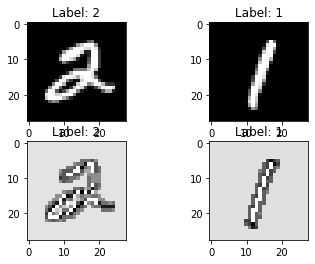

In [ ]:
# MNIST dataset
X_train = h5py.File('hdf5/mnist_x_train.hdf5', 'r')['images']
y_train = h5py.File('hdf5/mnist_y_train.hdf5', 'r')['labels']
X_test = h5py.File('hdf5/mnist_x_test.hdf5', 'r')['images']
y_test = h5py.File('hdf5/mnist_y_test.hdf5', 'r')['labels']

# Extract features using LBP
l1 = lbp(X_train[5].reshape(28, 28))
l2 = lbp(X_test[5].reshape(28, 28))

# First row: original images
plt.subplot(2,2,1)
plt.imshow(X_train[5].reshape(28, 28), cmap='gray')
plt.title('Label: ' + str(np.where(y_train[5] == 1)[0][0]))

plt.subplot(2,2,2)
plt.imshow(X_test[5].reshape(28, 28), cmap='gray')
plt.title('Label: ' + str(np.where(y_test[5] == 1)[0][0]))

# Second row: images after LBP
plt.subplot(2,2,3)
plt.imshow(l1, cmap='gray')
plt.title('Label: ' + str(np.where(y_train[5] == 1)[0][0]))

plt.subplot(2,2,4)
plt.imshow(l2, cmap='gray')
plt.title('Label: ' + str(np.where(y_test[5] == 1)[0][0]))


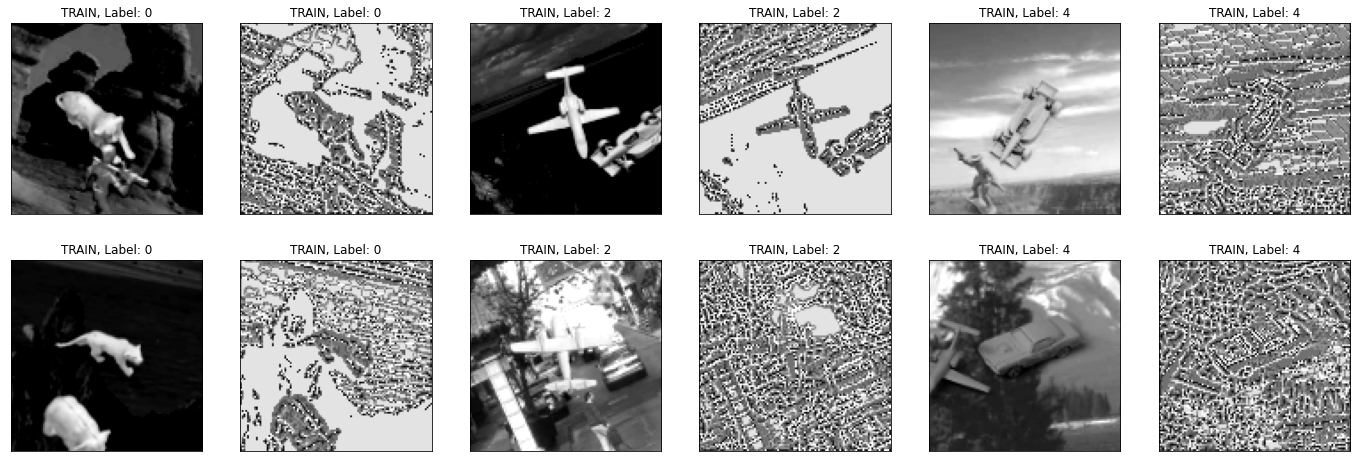

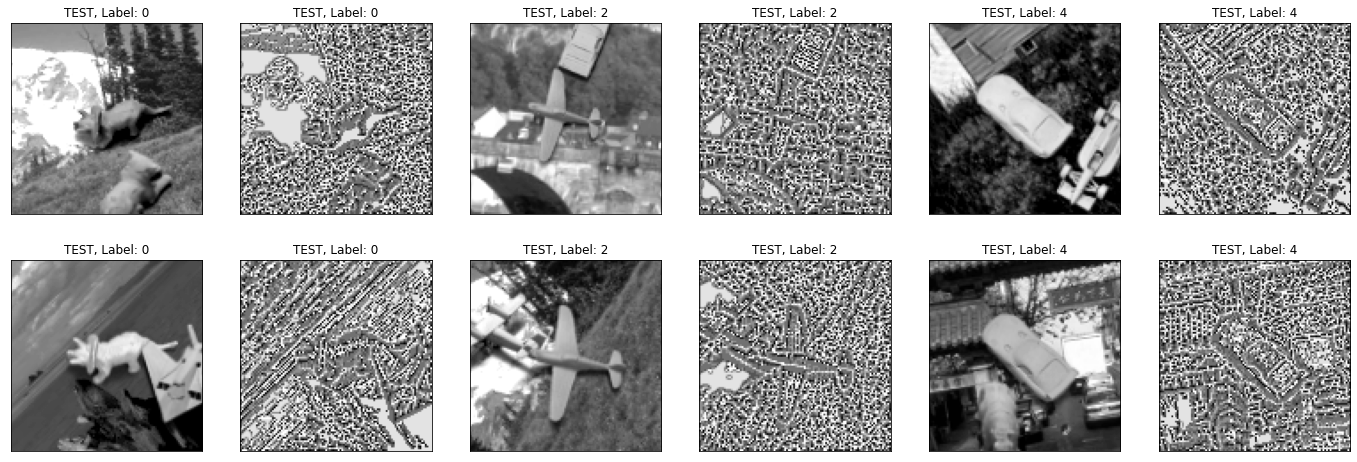

In [ ]:
def plot_NORB(prefix=''):
  img_size = 96 + 12 * (prefix=='')

  X_train = h5py.File('hdf5/' + prefix + 'norb_x_train.hdf5', 'r')['images']
  y_train = h5py.File('hdf5/' + prefix + 'norb_y_train.hdf5', 'r')['labels']
  X_test = h5py.File('hdf5/' + prefix + 'norb_x_test.hdf5', 'r')['images']
  y_test = h5py.File('hdf5/' + prefix + 'norb_y_test.hdf5', 'r')['labels']
  
  f = {'X_train': X_train, 'y_train': y_train, 'X_test': X_test, 'y_test': y_test}
  for ds in ['train', 'test']:
    images = f['X_' + ds]
    labels = f['y_' + ds]

    plt.figure(figsize=(24, 8))
    for i in range(0, 12, 2):
      # Odd columns: original images
      plt.subplot(2, 6, i+1)
      plt.imshow(images[i].reshape(img_size, img_size), cmap='gray')
      plt.title('{}, Label: {}'.format(ds.upper(), str((np.where(labels[i]==1))[0][0])))
      plt.grid(False)
      plt.xticks(ticks=[])
      plt.yticks(ticks=[])
      # Even columns: images after LBP
      plt.subplot(2, 6, i+2)
      plt.imshow(lbp(images[i].reshape(img_size, img_size)), cmap='gray')
      plt.title('{}, Label: {}'.format(ds.upper(), str((np.where(labels[i]==1))[0][0])))
      plt.grid(False)
      plt.xticks(ticks=[])
      plt.yticks(ticks=[])
      
# Label meaning:
# 0: animal, 
# 1: human
# 2: plane
# 3: truck
# 4: car
# 5: blank

plot_NORB(prefix='')

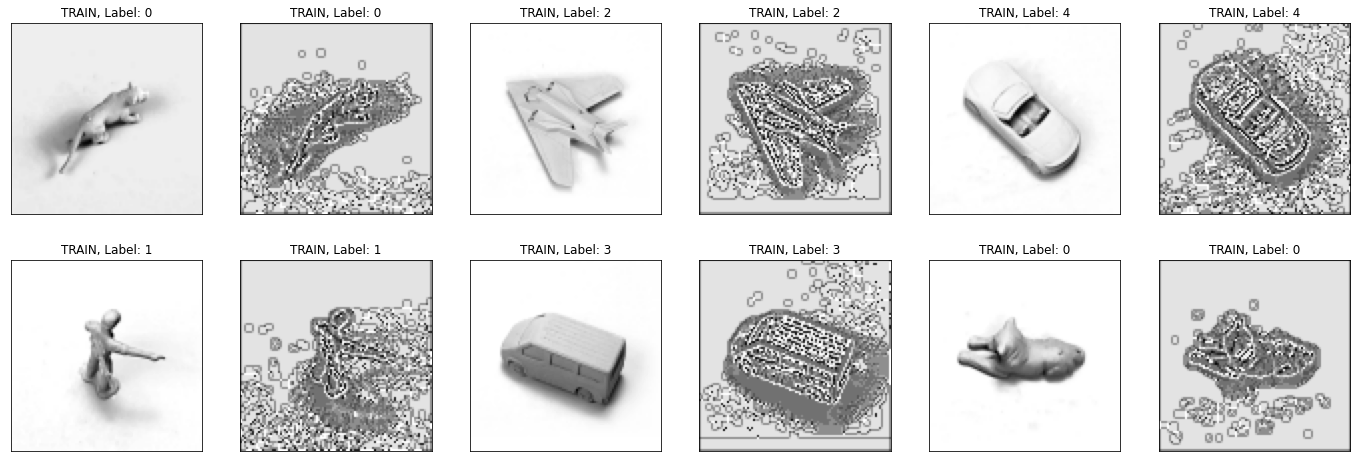

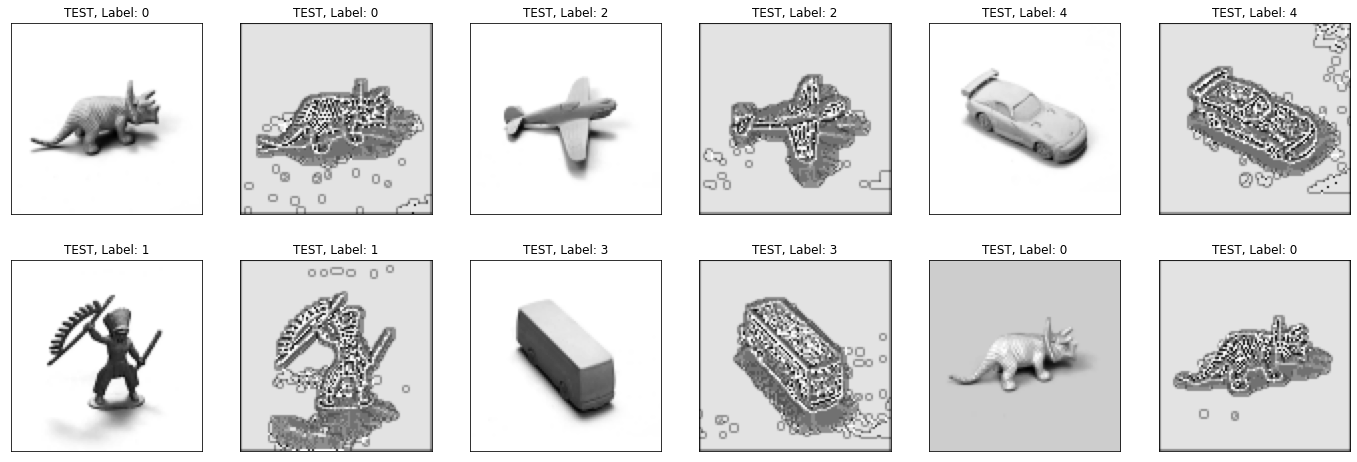

In [ ]:
# Small NORB dataset
# Images of toys with no background. 
plot_NORB(prefix='small')

# Main
The main routine trains ML models in 9 datasets. This routine takes a few minutes to process, so be patiente.

Train and Predict ML Models:
- Extreme Learning Machine (ELM)
- Single Layer Perceptron (SLP)
- Multi Layer Perceptron (MLP)
- Radial-Basis-Function Network (RBF)


Datasets:
- MNIST
- Small NORB
- NORB
- Australian
- Breast cancer
- Diabetes
- DNA
- Iris
- Wine

## Helper functions

In [ ]:
# ======================
# Data normalization
# ======================
# Each dependent variable is normalizaded using min-max or z-score.
# min-max transforms the values to fit in the range [0, 1].
# The formula is:
# x = (x - xmin) / (xmax - xmin),
# where 'xmax' is the maximum value and 'xmin' is the minimum value
# z-score uses normal distribution with mean = 0 and standard deviation = 1
def normalize(X, method, mu = 0, sd = 0, xmin = 0, xmax = 0):
    # Min - max
    if method == 'min-max':
        if xmin == 0 or xmax == 0:
            xmin = np.min(X)
            xmax = np.max(X)
        return (X - xmin) / (xmax - xmin), xmin, xmax
    
    # Norm Z
    elif method == 'z-score':
        if mu == 0 or sd == 0:
            mu = X.mean()
            sd = np.std(X)
        return (X - mu) / sd, mu, sd
    
    return None

def norm(X_train, X_test):

    for i in range(X_train.shape[1]):
        X_train[:, i], xmin, xmax = normalize(X = X_train[:, i],
                                              method = 'min-max')
        X_test[:, i], xmin, xmax = normalize(X = X_test[:, i], xmin = xmin,
                                             xmax = xmax, method = 'min-max')

# ==================================
# Load datasets
# - download the dataset
# - convert to one-hot encoding
# - create training and test sets
# - normalize X values in the range [0, 1]
# ==================================
# Multiple classes datasets
# ==================================

def load_dataset(dataset):
    dsname, ver = dataset  # dataset name and version
    if dsname == 'breast-cancer':
        ds = datasets.load_breast_cancer()
    else:
        ds = fetch_openml(name = dsname, version = ver)
    
    n_class = len(np.unique(ds.target))
    
    # Convert to one-hot encoded
    y = np.zeros((len(ds.target), n_class))
    for i in range(n_class):
        y[:, i] = np.where(ds.target == np.unique(ds.target)[i], 1, 0)
    
    # Normalize data
    X, _, _ = normalize(ds.data, method = 'z-score')

    # Randomize samples
    idx = np.random.permutation(range(len(X)))
    X = X[idx]
    y = y[idx]
    
    # Create train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

    return X_train, y_train, X_test, y_test

def elm_train(X_train, y_train, minibatch=None, input_size=None, hidden_size=None, 
              L=None, maxiter=None, plot=None, pdir=None, DS_name=None, **kwargs):

  if type(X_train) == h5py._hl.dataset.Dataset:
    model = HPELM
  else:
    model = ELM

  print('Running ' + model.__name__)
  elm = model(X_train.shape[1], y_train.shape[1], classification='c', batch=minibatch)
  elm.add_neurons(L, "sigm")
  elm.train(X_train, y_train)

  return elm

def elm_predict(X_test, elm, **kwargs):
  y_hat = elm.predict(X_test)
  return y_hat

In [ ]:
#@title Cross-validation method: select one
# Cross-validation method: 'random' or 'sequential'
sampling_method = "Leave-One-Out" #@param ["Cross-validation", "Leave-One-Out", "Bootstrap"]

# Result table
result_cv = pd.DataFrame(
    columns = ['Dataset', 'Model', 'Number of Neurons',
                'Train Accuracy (%)', 'Validation Accuracy (%)',
                'Test Accuracy (%)', 'Velocity (s)',
                'Standard Error', 'CI Lower Bound', 'CI Upper Bound'])

result_holdout = pd.DataFrame(
    columns = ['Dataset', 'Model', 'Number of Neurons',
                'Train Accuracy (%)', 'Validation Accuracy (%)'])

# Include new datasets in this list
# list of tuples: (dataset name, dataset version)
dataset = [('mnist', 0), 
           ('smallnorb', 0)
           #('norb', 0), 
           ('Australian', 4), ('breast-cancer', 1), ('diabetes', 1),
           ('dna', 1), ('iris', 1), ('wine', 1), 
           ]

models = {#'ELM': {'train': nn.elm_train, 'predict': nn.elm_predict},
          'ELM': {'train': elm_train, 'predict': elm_predict},
          'SLP': {'train': nn.slp_train, 'predict': nn.slp_predict},
          'MLP': {'train': nn.mlp_train, 'predict': nn.mlp_predict},
          'RBF': {'train': nn.rbf_train, 'predict': nn.rbf_predict}
          }

# Number of hidden layer neurons in ELM and MLP
neurons = [10, 20, 30, 40, 50, 100, 200, 300]

st = datetime.datetime.now()  # start processing time
print('Start time: ', st)
for ds in dataset:
    print('Processing:', ds[0])

    lr = True   # MLP variable learning rate
    # Load datasets
    if ds[0] == 'mnist':
      # Load full MNIST as NumPy array
      X_train = h5py.File('hdf5/mnist_x_train.hdf5', 'r')['images'][:]
      y_train = h5py.File('hdf5/mnist_y_train.hdf5', 'r')['labels'][:]
      X_test = h5py.File('hdf5/mnist_x_test.hdf5', 'r')['images'][:]
      y_test = h5py.File('hdf5/mnist_y_test.hdf5', 'r')['labels'][:]
      minibatch = X_train.shape[0] 
    elif ds[0] == 'norb':
      X_train = h5py.File('hdf5/norb_x_train.hdf5', 'r')['images']
      y_train = h5py.File('hdf5/norb_y_train.hdf5', 'r')['labels']
      X_test = h5py.File('hdf5/norb_x_test.hdf5', 'r')['images']
      y_test = h5py.File('hdf5/norb_y_test.hdf5', 'r')['labels']
      minibatch = 1000
    elif ds[0] == 'smallnorb':
      lr = False
      X_train = h5py.File('hdf5/smallnorb_x_train.hdf5', 'r')['images']
      y_train = h5py.File('hdf5/smallnorb_y_train.hdf5', 'r')['labels']
      X_test = h5py.File('hdf5/smallnorb_x_test.hdf5', 'r')['images']
      y_test = h5py.File('hdf5/smallnorb_y_test.hdf5', 'r')['labels']
      minibatch = X_train.shape[0] 
    else:
      X_train, y_train, X_test, y_test = load_dataset(dataset = ds)
      minibatch = X_train.shape[0]

    # Execute all models
    for model in models:
        print('Model: {}'. format(model))
        
        max_val_acc = 0
        Lmax=0
        #-----------------------
        # Use holdout to find the best number of hidden layer
        # neurons for each model.
        # -----------------------
        for L in neurons:
            # Train data
            if model == 'RBF':      # For RBF network, the number of neurons
              L = y_train.shape[1]  # is equal to the number of classes
            params = models[model]['train'](X_train, y_train,
                                            input_size = X_train.shape[1],
                                            minibatch = minibatch,
                                            var_lr = lr,
                                            hidden_size = len(X_test),
                                            L = L,          # Number of hidden layer neurons
                                            maxiter = 100,  # Maximum number of epochs
                                            plot = False,   # create plot
                                            pdir = '', DS_name = '')
            
            # Train Accuracy
            y_hat = models[model]['predict'](X_train, params)
            y_hat = (y_hat == np.max(y_hat, axis = 1, keepdims = True)) * 1
            tr_acc = np.round(100 * np.mean(y_train[:] == y_hat), 2)
            
            # Validation Accuracy
            y_hat = models[model]['predict'](X_test, params)
            y_hat = (y_hat == np.max(y_hat, axis = 1, keepdims = True)) * 1
            val_acc = np.round(100 * np.mean(y_test[:] == y_hat), 2)

            # Keep parameters of best validation accuracy
            if val_acc > max_val_acc:
                max_val_acc = val_acc   # accuracy
                Lmax = L                # number of hidden layer neurons
                e_hat = 1 - np.mean(y_test[:] == y_hat)         # validation error
                se = np.sqrt(e_hat * (1-e_hat)/len(X_test))  # standard error

            # Update result table
            end_time = timeit.default_timer()
            result_holdout.loc[len(result_holdout) + 1] = [ds[0].title(), model, L,
                                            tr_acc, val_acc]

            # Exit cross validation if model is SLP or RBF, since they've no hidden layer neurons
            if model in ['SLP', 'RBF']:
                break

        #-----------------------
        # k-fold cross validation to compute true error and confidence interval
        #-----------------------
        N = len(X_train)
        if sampling_method == "Leave-One-Out":
          K = N
        else:
          K = 5   # Number of cross-validation folds
        train_acc = np.zeros(K)   # Train accuracy
        train_err = np.zeros(K)   # Train error
        test_acc = np.zeros(K)    # Test accuracy
        test_err = np.zeros(K)    # Test error

        for k in range(K):
            if sampling_method in ["Cross-validation", "Leave-One-Out"]:
              # Create train and validation sets
              # Define K% of rows for validation set
              val_idx = np.array(range(int(N * k / K),
                                  int(N * (k + 1) / K)))

              # Define complementary row numbers for train set
              train_idx = np.setdiff1d(np.array(range(X_train.shape[0])), val_idx)
            elif sampling_method == 'Bootstrap':
              val_percent = 0.2
              val_size = int(N * val_percent)
              train_size = int(N * (1 - val_percent))

#              train_idx = np.random.choice(np.arange(N), train_size)  # train_set
#              val_idx = [i for i in set(np.arange(N)) - set(train_idx)]
#              val_idx = np.random.choice(val_idx, val_size)

              train_idx = np.random.choice(np.arange(N), N)  # train_set
              val_idx = [i for i in set(np.arange(N)) - set(train_idx)]
              #val_idx = np.random.choice(val_idx, val_size)

            X1, y1 = X_train[train_idx], y_train[train_idx]     # Train set
            X2, y2 = X_train[val_idx], y_train[val_idx]         # Validation set
            
            # Train and test with best parameters
            start_time = timeit.default_timer()
            params = models[model]['train'](X1, y1,
                                            input_size = X1.shape[1],
                                            minibatch = minibatch,
                                            hidden_size = len(X2),
                                            L = Lmax,  # Number of hidden layer neurons
                                            maxiter = 100, # Maximum number of epochs
                                            plot = False,  # create plot
                                            pdir = '', DS_name = '')

            # Train accuracy and loss
            y_hat = models[model]['predict'](X1, params)
            y_hat = (y_hat == np.max(y_hat, axis = 1, keepdims = True)) * 1
            train_acc[k] = np.round(100 * np.mean(y1 == y_hat), 2)
            train_err[k] = 1 - np.mean(y1 == y_hat)
            
            # Test accuracy and loss
            y_hat = models[model]['predict'](X2, params)
            y_hat = (y_hat == np.max(y_hat, axis = 1, keepdims = True)) * 1
            test_acc[k] = np.round(100 * np.mean(y2 == y_hat), 2)
            test_err[k] = 1 - np.mean(y2 == y_hat)

        # Cross-validation accuracy and loss
        cv_train_acc = np.mean(train_acc)
        cv_train_err = np.mean(train_err)
        cv_test_acc = np.mean(test_acc)
        cv_test_err = np.mean(test_err)

        # Standard deviation
        cv_train_sd = np.std(train_err)
        cv_test_sd = np.std(test_acc)

        absolut_difference_test = cv_test_acc / cv_test_sd
        print('\n Diferença Absoluta:')
        print(absolut_difference_test)
        print('\n')


        # Standard error and Confidence Interval
        se = np.sqrt(cv_train_err * (1-cv_train_err) / N)   # standard error
        cilb = cv_train_err - 1.96 * se     # confidence interval - lower bound
        ciub = cv_train_err + 1.96 * se     # confidence interval - upper bound
        
        # Update result table
        end_time = timeit.default_timer()
        velocity = end_time - start_time
        result_cv.loc[len(result_cv) + 1] = [ds[0].title(), model, Lmax,
                                        cv_train_acc, max_val_acc, cv_test_acc,
                                        velocity, se, cilb, ciub]
    
# Save and print result table
et = datetime.datetime.now()
result_cv.to_csv("result/result_{}_{}.csv".format(sampling_method, et.strftime("%Y-%m-%d_%H-%M-%S")),  sep='\t', index=False)
result_holdout.to_csv("result/result_holdout_{}.csv".format(et.strftime("%Y-%m-%d_%H-%M-%S")),  sep='\t', index=False)
print(result_cv)
print(result_holdout)

print('End time:', et)
print('Duration:', et - st)


Start time:  2020-12-09 22:54:00.118864
Processing: Australian
Model: ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Ru


 10%|█         | 10/100 [00:00<00:00, 98.80it/s]


 Diferença Absoluta:
0.9574271077563383


Model: MLP



100%|██████████| 100/100 [00:00<00:00, 123.83it/s]

100%|██████████| 100/100 [00:01<00:00, 84.96it/s]

100%|██████████| 100/100 [00:01<00:00, 75.23it/s]

100%|██████████| 100/100 [00:02<00:00, 34.26it/s]

100%|██████████| 100/100 [00:03<00:00, 30.87it/s]

100%|██████████| 100/100 [00:05<00:00, 18.16it/s]

100%|██████████| 100/100 [00:09<00:00, 10.54it/s]

100%|██████████| 100/100 [00:18<00:00,  5.27it/s]

100%|██████████| 100/100 [00:00<00:00, 361.14it/s]

100%|██████████| 100/100 [00:00<00:00, 431.01it/s]

100%|██████████| 100/100 [00:00<00:00, 407.74it/s]

100%|██████████| 100/100 [00:00<00:00, 425.84it/s]

100%|██████████| 100/100 [00:00<00:00, 415.41it/s]

100%|██████████| 100/100 [00:00<00:00, 476.45it/s]

100%|██████████| 100/100 [00:00<00:00, 427.36it/s]

100%|██████████| 100/100 [00:00<00:00, 419.98it/s]

100%|██████████| 100/100 [00:00<00:00, 419.25it/s]

100%|██████████| 100/100 [00:00<00:00, 434.65it/s]

100%|██████████| 100/100 [00:00<00:00, 432.51it/s]

100%|██████████| 1


 Diferença Absoluta:
0.8673989580239028


Model: RBF

 Diferença Absoluta:
1.1571443517761548


Processing: breast-cancer
Model: ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Ru


 10%|█         | 10/100 [00:00<00:00, 98.07it/s]


 Diferença Absoluta:
0.7832465622682072


Model: MLP



100%|██████████| 100/100 [00:00<00:00, 131.04it/s]

100%|██████████| 100/100 [00:01<00:00, 62.38it/s]

100%|██████████| 100/100 [00:02<00:00, 47.84it/s]

100%|██████████| 100/100 [00:02<00:00, 38.49it/s]

100%|██████████| 100/100 [00:02<00:00, 34.95it/s]

100%|██████████| 100/100 [00:05<00:00, 19.47it/s]

100%|██████████| 100/100 [00:10<00:00,  9.92it/s]

100%|██████████| 100/100 [00:13<00:00,  7.16it/s]

100%|██████████| 100/100 [00:00<00:00, 411.97it/s]

100%|██████████| 100/100 [00:00<00:00, 427.77it/s]

100%|██████████| 100/100 [00:00<00:00, 388.64it/s]

100%|██████████| 100/100 [00:00<00:00, 408.48it/s]

100%|██████████| 100/100 [00:00<00:00, 432.68it/s]

100%|██████████| 100/100 [00:00<00:00, 415.82it/s]

100%|██████████| 100/100 [00:00<00:00, 401.46it/s]

100%|██████████| 100/100 [00:00<00:00, 395.32it/s]

100%|██████████| 100/100 [00:00<00:00, 383.14it/s]

100%|██████████| 100/100 [00:00<00:00, 397.98it/s]

100%|██████████| 100/100 [00:00<00:00, 403.28it/s]

100%|██████████| 1


 Diferença Absoluta:
1.2767371708649389


Model: RBF

 Diferença Absoluta:
2.8460498941515415


Processing: diabetes
Model: ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running


  9%|▉         | 9/100 [00:00<00:01, 83.87it/s]


 Diferença Absoluta:
1.565068114251642


Model: MLP



100%|██████████| 100/100 [00:00<00:00, 115.99it/s]

100%|██████████| 100/100 [00:01<00:00, 77.96it/s]

100%|██████████| 100/100 [00:01<00:00, 59.54it/s]

100%|██████████| 100/100 [00:01<00:00, 53.13it/s]

100%|██████████| 100/100 [00:02<00:00, 40.09it/s]

100%|██████████| 100/100 [00:06<00:00, 15.09it/s]

100%|██████████| 100/100 [00:15<00:00,  6.49it/s]

100%|██████████| 100/100 [00:19<00:00,  5.22it/s]

100%|██████████| 100/100 [00:00<00:00, 389.70it/s]

100%|██████████| 100/100 [00:00<00:00, 449.35it/s]

100%|██████████| 100/100 [00:00<00:00, 461.24it/s]

100%|██████████| 100/100 [00:00<00:00, 438.70it/s]

100%|██████████| 100/100 [00:00<00:00, 466.31it/s]

100%|██████████| 100/100 [00:00<00:00, 433.41it/s]

100%|██████████| 100/100 [00:00<00:00, 437.20it/s]

100%|██████████| 100/100 [00:00<00:00, 423.83it/s]

100%|██████████| 100/100 [00:00<00:00, 458.60it/s]

100%|██████████| 100/100 [00:00<00:00, 422.98it/s]

100%|██████████| 100/100 [00:00<00:00, 437.05it/s]

100%|██████████| 1


 Diferença Absoluta:
0.7605301898450908


Model: RBF

 Diferença Absoluta:
1.178603011351048


Processing: dna
Model: ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
R


  2%|▏         | 2/100 [00:00<00:08, 11.20it/s]


 Diferença Absoluta:
1.7489266753426502


Model: MLP


Streaming output truncated to the last 5000 lines.
100%|██████████| 100/100 [00:00<00:00, 351.42it/s]

100%|██████████| 100/100 [00:00<00:00, 367.61it/s]

100%|██████████| 100/100 [00:00<00:00, 310.60it/s]

100%|██████████| 100/100 [00:00<00:00, 344.67it/s]

100%|██████████| 100/100 [00:00<00:00, 363.72it/s]

100%|██████████| 100/100 [00:00<00:00, 372.01it/s]

100%|██████████| 100/100 [00:00<00:00, 349.50it/s]

100%|██████████| 100/100 [00:00<00:00, 305.59it/s]

100%|██████████| 100/100 [00:00<00:00, 334.86it/s]

100%|██████████| 100/100 [00:00<00:00, 331.65it/s]

100%|██████████| 100/100 [00:00<00:00, 353.94it/s]

100%|██████████| 100/100 [00:00<00:00, 347.90it/s]

100%|██████████| 100/100 [00:00<00:00, 303.19it/s]

100%|██████████| 100/100 [00:00<00:00, 386.28it/s]

100%|██████████| 100/100 [00:00<00:00, 359.23it/s]

100%|██████████| 100/100 [00:00<00:00, 346.16it/s]

100%|██████████| 100/100 [00:00<00:00, 345.58it/s]

100%|██████████| 100/100 [00:00<00:00, 284.26it/s]

100%|████████


 Diferença Absoluta:
1.8856270046812027


Model: RBF

 Diferença Absoluta:
2.1216208175056455


Processing: iris
Model: ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons
Running ELM
Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running

/usr/local/lib/python3.6/dist-packages/hpelm/nnets/slfn_python.py:65: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  B = np.linalg.lstsq(HH, HT)[0]



Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM

 Diferença Absoluta:
5.409915842627175


Model: SLP



 16%|█▌        | 16/100 [00:00<00:00, 153.46it/s]


 Diferença Absoluta:
1.7336655777504166


Model: MLP



100%|██████████| 100/100 [00:00<00:00, 181.15it/s]

100%|██████████| 100/100 [00:00<00:00, 151.83it/s]

100%|██████████| 100/100 [00:00<00:00, 127.51it/s]

100%|██████████| 100/100 [00:00<00:00, 121.79it/s]

100%|██████████| 100/100 [00:00<00:00, 110.14it/s]

100%|██████████| 100/100 [00:01<00:00, 73.04it/s]

100%|██████████| 100/100 [00:02<00:00, 46.80it/s]

100%|██████████| 100/100 [00:03<00:00, 26.59it/s]

100%|██████████| 100/100 [00:00<00:00, 419.87it/s]

100%|██████████| 100/100 [00:00<00:00, 430.80it/s]

100%|██████████| 100/100 [00:00<00:00, 435.19it/s]

100%|██████████| 100/100 [00:00<00:00, 422.77it/s]

100%|██████████| 100/100 [00:00<00:00, 432.75it/s]

100%|██████████| 100/100 [00:00<00:00, 340.35it/s]

100%|██████████| 100/100 [00:00<00:00, 392.78it/s]

100%|██████████| 100/100 [00:00<00:00, 388.10it/s]

100%|██████████| 100/100 [00:00<00:00, 387.55it/s]

100%|██████████| 100/100 [00:00<00:00, 384.90it/s]

100%|██████████| 100/100 [00:00<00:00, 394.41it/s]

100%|█████████


 Diferença Absoluta:
1.7745048900415927


Model: RBF

 Diferença Absoluta:
3.4869466076470688


Processing: wine
Model: ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons
Running ELM
Covariance matrix is not full rank; solving with SVD (slow)
This happened because you have duplicated or too many neurons
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running ELM
Running


 16%|█▌        | 16/100 [00:00<00:00, 156.58it/s]


 Diferença Absoluta:
2.050962367426058


Model: MLP



100%|██████████| 100/100 [00:00<00:00, 201.40it/s]

100%|██████████| 100/100 [00:00<00:00, 174.23it/s]

100%|██████████| 100/100 [00:00<00:00, 148.41it/s]

100%|██████████| 100/100 [00:00<00:00, 126.32it/s]

100%|██████████| 100/100 [00:00<00:00, 126.36it/s]

100%|██████████| 100/100 [00:01<00:00, 77.32it/s]

100%|██████████| 100/100 [00:03<00:00, 25.09it/s]

100%|██████████| 100/100 [00:05<00:00, 19.39it/s]

100%|██████████| 100/100 [00:00<00:00, 409.05it/s]

100%|██████████| 100/100 [00:00<00:00, 464.54it/s]

100%|██████████| 100/100 [00:00<00:00, 468.02it/s]

100%|██████████| 100/100 [00:00<00:00, 488.59it/s]

100%|██████████| 100/100 [00:00<00:00, 481.10it/s]

100%|██████████| 100/100 [00:00<00:00, 455.90it/s]

100%|██████████| 100/100 [00:00<00:00, 451.75it/s]

100%|██████████| 100/100 [00:00<00:00, 471.82it/s]

100%|██████████| 100/100 [00:00<00:00, 465.14it/s]

100%|██████████| 100/100 [00:00<00:00, 429.68it/s]

100%|██████████| 100/100 [00:00<00:00, 457.45it/s]

100%|█████████


 Diferença Absoluta:
1.7434635297201713


Model: RBF

 Diferença Absoluta:
2.484102397939209


          Dataset Model  ... CI Lower Bound  CI Upper Bound
1      Australian   ELM  ...       0.093463        0.147805
2      Australian   SLP  ...       0.480067        0.563411
3      Australian   MLP  ...       0.529359        0.611945
4      Australian   RBF  ...       0.368499        0.450545
5   Breast-Cancer   ELM  ...       0.027267        0.066019
6   Breast-Cancer   SLP  ...       0.575175        0.664386
7   Breast-Cancer   MLP  ...       0.335614        0.424825
8   Breast-Cancer   RBF  ...       0.078426        0.135187
9        Diabetes   ELM  ...       0.193290        0.259495
10       Diabetes   SLP  ...       0.254014        0.325791
11       Diabetes   MLP  ...       0.595438        0.671663
12       Diabetes   RBF  ...       0.367535        0.445235
13            Dna   ELM  ...       0.024232        0.037683
14            Dna   SLP  ...       0.443225        0.481945
15  

## Create Plots

ymin: 50.0


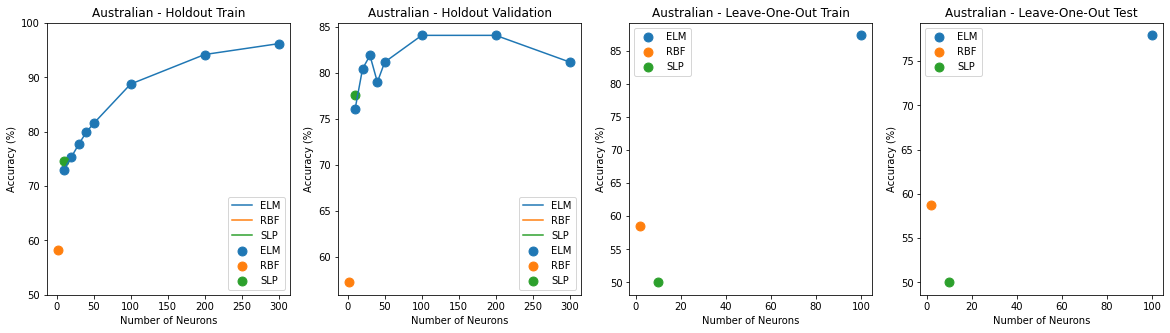

ymin: 37.582417582417584


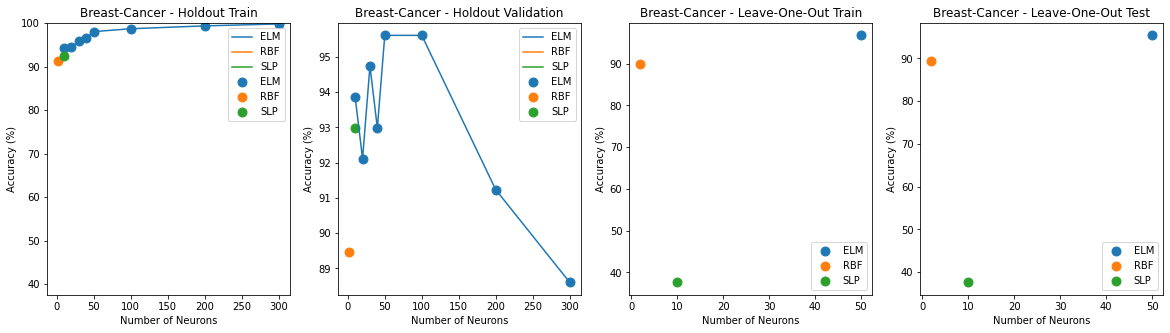

ymin: 71.43


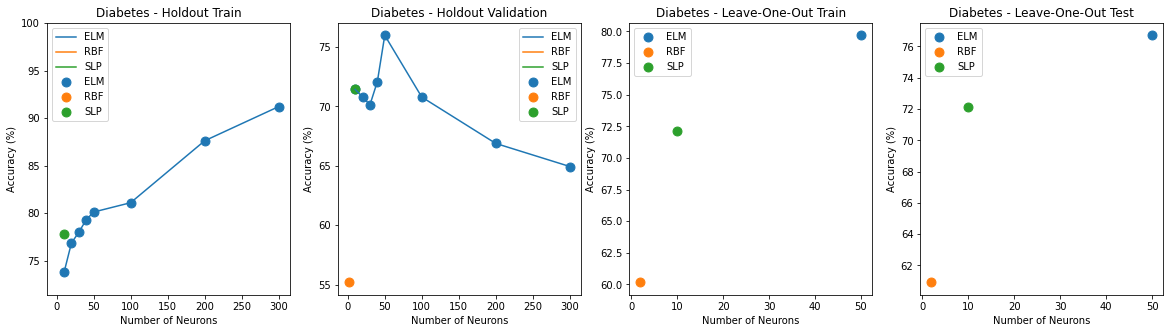

ymin: 53.58218995290423


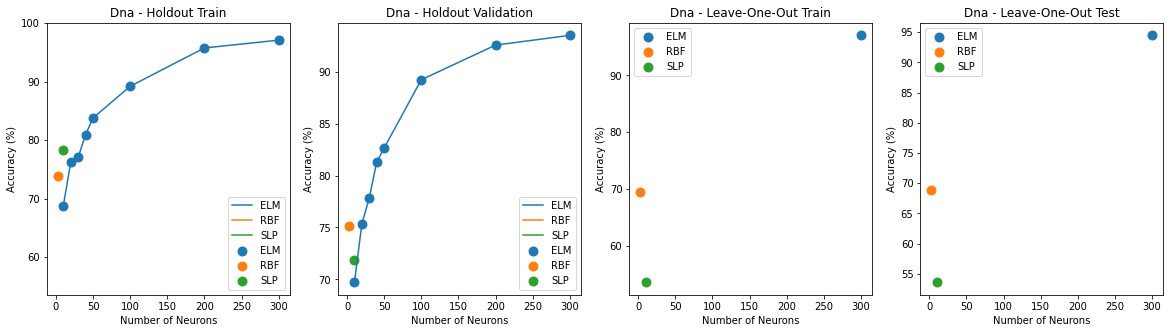

ymin: 47.219583333333325


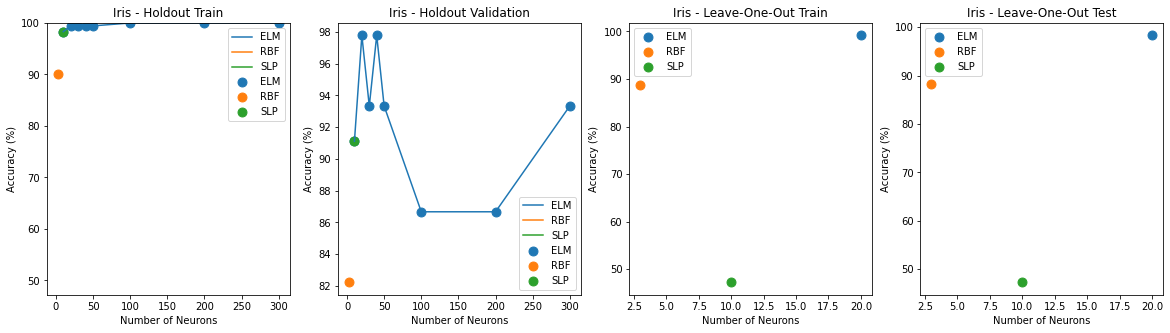

ymin: 37.555563380281676


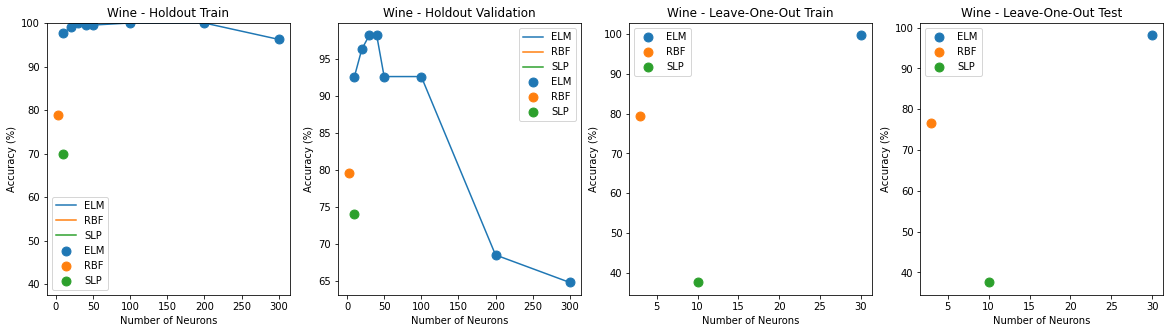

In [ ]:
#@title
#========================================
# Create scatter plots 
#========================================
models = [model for model in np.unique(result_holdout['Model'])]
for ds in np.unique(result_holdout['Dataset']):

    _, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,5))
    for model in models:
        x1 = result_holdout[(result_holdout['Dataset'] == ds) & (result_holdout['Model'] == model)]['Number of Neurons']
        y1_1 = result_holdout[(result_holdout['Dataset'] == ds) & (result_holdout['Model'] == model)]['Train Accuracy (%)']
        y1_2 = result_holdout[(result_holdout['Dataset'] == ds) & (result_holdout['Model'] == model)]['Validation Accuracy (%)']

        x2 = result_cv[(result_cv['Dataset'] == ds) & (result_cv['Model'] == model)]['Number of Neurons']
        y2_1 = result_cv[(result_cv['Dataset'] == ds) & (result_cv['Model'] == model)]['Train Accuracy (%)']
        y2_2 = result_cv[(result_cv['Dataset'] == ds) & (result_cv['Model'] == model)]['Test Accuracy (%)']

        ax1.plot(x1, y1_1, label = model)             # Holdout: Train
        ax1.scatter(x1, y1_1, s = 80, label = model)  # Holdout: Train
        ax2.plot(x1, y1_2, label = model)             # Holdout: Validation
        ax2.scatter(x1, y1_2, s = 80,label = model)   # Holdout: Validation
        ax3.scatter(x2, y2_1, s = 80, label = model)  # CV: Train
        ax4.scatter(x2, y2_2, s = 80, label = model)  # CV: Test


    ymin = np.min(np.hstack((y1_1, y1_2, y2_1, y2_2)))
    print('ymin:', ymin)
    # Holdout: Train accuracy
    ax1.set_title(ds + ' - Holdout Train')
    ax1.set_xlabel('Number of Neurons')
    ax1.set_ylabel('Accuracy (%)')
    ax1.set_ylim([ymin,100])
    ax1.legend()

    # Holdout: Validation accuracy
    ax2.set_title(ds + ' - Holdout Validation')
    ax2.set_xlabel('Number of Neurons')
    ax2.set_ylabel('Accuracy (%)')
    ax1.set_ylim([ymin,100])
    ax2.legend()

    # Cross-validation: Train accuracy
    ax3.set_title(ds + ' - ' + sampling_method + ' Train')
    ax3.set_xlabel('Number of Neurons')
    ax3.set_ylabel('Accuracy (%)')
    ax1.set_ylim([ymin,100])
    ax3.legend()

    # Cross-validation: Test accuracy
    ax4.set_title(ds + ' - ' + sampling_method + ' Test')
    ax4.set_xlabel('Number of Neurons')
    ax4.set_ylabel('Accuracy (%)')
    ax1.set_ylim([ymin,100])
    ax4.legend()

    # Save and show plot
    if not os.path.exists('plot/'):
      os.mkdir('plot/')
    plt.savefig('plot/' + sampling_method + "_" + ds + '.png',
                dpi = 300, bbox_inches = 'tight')
    plt.show()


# Miscelaneous
## Download plots and results
This code downloads the plots above and tables to your computer.

In [ ]:
%%bash
ls -lh plot

echo
echo result directory:
ls -lh result

In [ ]:
# Download results and plots
try:
  from google.colab import files
except ImportError:
  pass
else:
  for fname in glob.glob('plot/*'):
    files.download(fname)
  for fname in glob.glob('result/*'):
    files.download(fname)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Hardware and software information
This is the HW and SW confiration of this Colab VM. 

In [ ]:
!apt install lshw

In [ ]:
%%bash
echo ========================
echo Memory Info \(GB\):
echo ========================
free -g

echo ========================
echo CPU Info:
echo ========================
lscpu

echo ========================
echo Disk space
echo ========================
df -h

echo ========================
echo Linux version
echo ========================
lsb_release -a

echo ========================
echo GPU
echo ========================
nvidia-smi

echo
lshw -C display

In [ ]:
import sys
print("===============")
print("Python version")
print("===============")
print("Python: " + sys.version.split('\n')[0])
print("NumPy: " + np.__version__)
print("Pandas: " + pd.__version__)
print("h5py: " + h5py.__version__)